PROVA 02 - INTRODUÇÃO A INTELIGÊNCIA ARTIFICIAL



Utilize validação cruzada estratificada 10-fold e fixe o random_state para responder, se necessário. O código deve estar no collab ou github.





Utilizando a base de dados de:  https://tmfilho.github.io/akcdata/


Lembre-se de comentar seu código no notebook detalhadamente, explicando cada passo.


Faça o pré-processamento dos dados e deixe os seus dados preparados para aplicar o modelo.



OBS: Utilize pelo menos uma forma de redimensionamento de atributos (selecionando automaticamente ou agregando) e avalie o resultado de utilizar todos eles e essa amostra.



Teste algoritmos de Árvore de Decisão, Naive Bayes e MLP. 



Para avaliar os resultados,  use F1-score e matriz de confusão.



Utilize a mesma base de dados (lembrem de tirar o rótulo, obviamente) da questão anterior de forma que:


 


Execute o K-means e Hierárquico.



Avalie o K-means com o valor de K no teste do cotovelo e com o esse valor, compare com o hierárquico.



Na execução do Hierárquico, varie 2 métodos do linkage, com o mesmo valor de K.



Por fim, faça uma comparação entre os 2 resultados das execuções anteriores e adote uma medida de avaliação própria para clusterização.



### Imports iniciais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering
import scipy.cluster.hierarchy as sch


### Pré-Processamento


In [2]:
df = pd.read_csv("akc-data-latest.csv")

In [3]:
df.head()

,Unnamed: 0,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,...,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

dropando colunas de tipo object, exceto a coluna popularidade e a group, que eu vou usar na classificação

In [5]:

object_cols = df.select_dtypes(include=['object']).columns
object_cols = object_cols.drop(["popularity","group"])

df = df.drop(columns=object_cols)

In [6]:
df.isna().sum()

popularity                  79
min_height                   0
max_height                   0
min_weight                   2
max_weight                   2
min_expectancy               3
max_expectancy               3
group                        0
grooming_frequency_value     7
shedding_value              20
energy_level_value           6
trainability_value          24
demeanor_value              25
dtype: int64

### Agregação de colunas

Agregando as colunas com valores de máximo e mínimo, a partir da média


In [7]:

df['average_height'] = df[['min_height', 'max_height']].mean(axis=1)
df['average_weight'] = df[['min_weight', 'max_weight']].mean(axis=1)
df['average_expectancy'] = df[['min_expectancy', 'max_expectancy']].mean(axis=1)


df.drop(columns=['min_height', 'max_height', 'min_weight', 'max_weight', 
                 'min_expectancy', 'max_expectancy'], inplace=True)


In [8]:
#Transformando a coluna popularidade (que era object) em numérica, e preenchendo os valores nulos com a média

df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

df = df.apply(lambda x: x.fillna(x.mean()) if x.name != 'group' else x, axis=0)

In [9]:
df2 = df

### Normalizando os dados

In [10]:
df.set_index('group', inplace=True)

In [11]:
#Normalizando os dados com MinMaxScaler
scaler = MinMaxScaler()

df_esc = scaler.fit_transform(df)
df_esc = pd.DataFrame(df_esc, columns=df.columns, index=df.index)
df = df_esc

### Correlação

Criando um gráfico de correlação pra entender o relacionamento entre as variáveis


In [12]:
df.reset_index(inplace=True)

<Axes: >

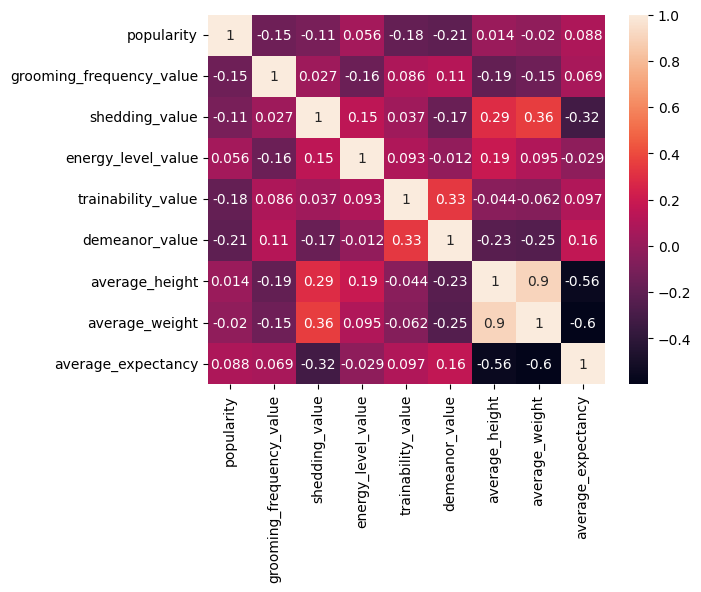

In [13]:
correlacao = df.drop("group", axis=1).corr(method='spearman')
sns.heatmap(correlacao, annot=True)

como a coluna de avarage_height e average_weight são muito correlacionadas, vou dropar uma delas


In [14]:
df.drop(columns=['average_weight'], inplace=True)

# Supervisionado

### Divisão entre treino e teste

In [15]:
#Dividindo o dataset em treino e teste, usando random state em 42 para garantir a aleatoriedade da divisão
X_train, X_test, y_train, y_test = train_test_split(df.drop("group", axis=1), df["group"], test_size=0.25, random_state=42)


In [16]:
df.isna().sum()

group                       0
popularity                  0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
average_height              0
average_expectancy          0
dtype: int64

Fazendo um resampling dos dados para balancear as classes


In [17]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_resampled.value_counts() 

Sporting Group              51
Terrier Group               51
Working Group               51
Foundation Stock Service    51
Herding Group               51
Miscellaneous Class         51
Hound Group                 51
Non-Sporting Group          51
Toy Group                   51
Name: group, dtype: int64

## Naive Bayes

In [18]:
model = GaussianNB()

model.fit(X_resampled, y_resampled)

GaussianNB()

### Avaliação de resultados

In [19]:
value = df['group'].unique()

<Figure size 1000x700 with 0 Axes>

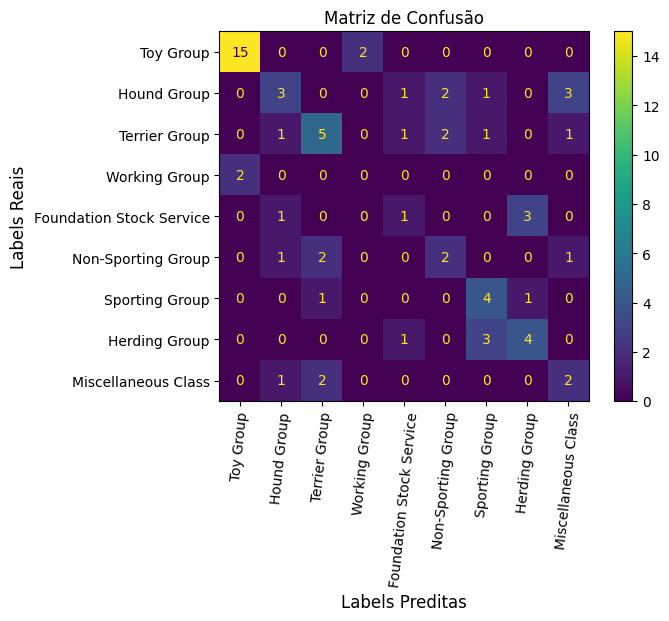

In [20]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Matriz de Confusão')
plt.xlabel('Labels Preditas', fontsize=12)
plt.ylabel('Labels Reais', fontsize=12)
plt.xticks(rotation=84)  
plt.show()


#Criando uma matriz de confusão para entender os resultados da classificação. 


É possível observar nessa matriz de confusão que o único dos resultados que ele está acertando com facilidade é o do Toy Group, já para os outros, o modelo acaba se confundindo muito, o que pode ser a causa da acurácia estar tão baixa

In [21]:
accuracy_nayve = accuracy_score(y_test, y_pred) * 100
precision_nayve = precision_score(y_test, y_pred, average='weighted') * 100
recall_nayve = recall_score(y_test, y_pred, average='weighted') * 100
f1_nayve = f1_score(y_test, y_pred, average='weighted') * 100

print(f'Accuracy: {accuracy_nayve:.2f}%')
print(f'Precision: {precision_nayve:.2f}%')
print(f'Recall: {recall_nayve:.2f}%')
print(f'F1 Score: {f1_nayve:.2f}%')



Accuracy: 51.43%
Precision: 51.62%
Recall: 51.43%
F1 Score: 51.06%


Os resultados das métricas de avaliação não foram tão bons, isso é decorrente da baixa quantidade de dados que foram apresentados para o modelo. Mesmo que algumas técnicas de resampling, para balanceamento de dados, fossem utilizadas, a resposta dele ainda não se mostrou muito útil para uma situação de classificação do mundo real, visto que o modleo é pouco melhor do que o lançamento de uma moeda por exemplo.

## Random Forest

Usei uma forma de pegar os hiperparâmetros de melhor resultado para colocar na minha árvore, afim de encontrar o melhor resultado possível para o modelo dadas as circunstâncias.

In [22]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf = RandomForestClassifier()

param_dist = {
    'n_estimators': randint(100, 1000), 
    'max_depth': randint(1, 50),        
    'min_samples_split': randint(2, 11),
    'max_features': ['sqrt', 'log2'],   
}

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 n_iter=100,  
                                 cv=5,        
                                 n_jobs=-1)   

rand_search.fit(X_resampled, y_resampled)

best_rf = rand_search.best_estimator_

print('Best Hyperparameters:', rand_search.best_params_)


max_depth = rand_search.best_params_['max_depth']
max_features = rand_search.best_params_['max_features']
min_samples_split = rand_search.best_params_['min_samples_split']
n_estimators = rand_search.best_params_['n_estimators']

Best Hyperparameters: {'max_depth': 44, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 314}


In [23]:
rf = RandomForestClassifier(max_depth= max_depth, n_estimators= n_estimators, min_samples_split= min_samples_split, max_features= max_features)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=44, max_features='log2', n_estimators=314)

### Avaliação de resultados

In [24]:
accuracy_rand = accuracy_score(y_test, y_pred) * 100
precision_rand = precision_score(y_test, y_pred, average='weighted') * 100
recall_rand = recall_score(y_test, y_pred, average='weighted') * 100
f1_rand = f1_score(y_test, y_pred, average='weighted') * 100

print(f'Accuracy: {accuracy_rand:.2f}%')
print(f'Precision: {precision_rand:.2f}%')
print(f'Recall: {recall_rand:.2f}%')
print(f'F1 Score: {f1_rand:.2f}%')

Accuracy: 51.43%
Precision: 51.62%
Recall: 51.43%
F1 Score: 51.06%


O modelo Random Forest também apresentou um desempenho ruim, com resultados similares ao Naive Bayes.
Ainda assim, o uso desse modelo apresenta muitas vantagens, principalmente devido à explicabilidade dos resultados gerados
e a visualização dos atributos mais importantes para a classificação, sendo essa uma das principais razões para a escolha
dele.

In [25]:
y_test.value_counts()

Foundation Stock Service    17
Hound Group                 11
Herding Group               10
Toy Group                    8
Sporting Group               6
Terrier Group                6
Non-Sporting Group           5
Working Group                5
Miscellaneous Class          2
Name: group, dtype: int64

<Figure size 1000x700 with 0 Axes>

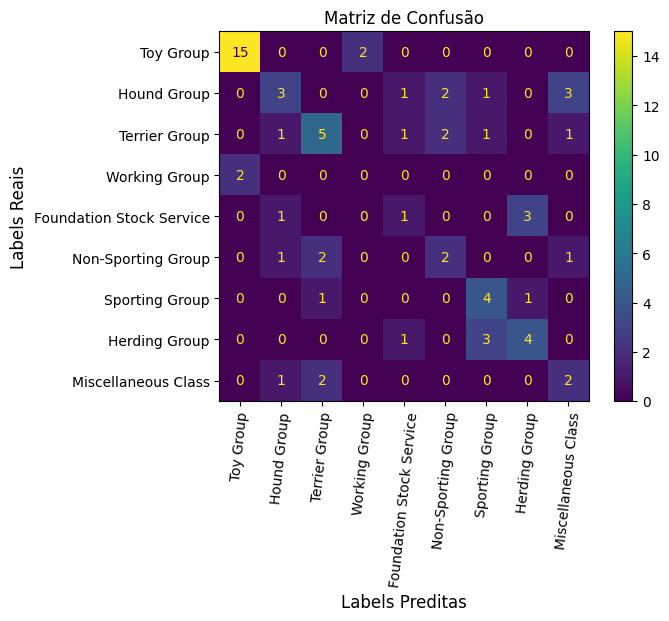

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Matriz de Confusão')
plt.xlabel('Labels Preditas', fontsize=12)
plt.ylabel('Labels Reais', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

Assim como a matriz de confusão do Nayve Bayes, o modelo também apresentou um resultado pouco promissor, errando consideravelmente na parte majoritária dos grupos.

#### Features de maior importância

Uma das principais vantagens de uso de Random Forest é a possibilidade de verificar a importância das features


C:\Users\felip\AppData\Local\Temp\ipykernel_16408\328696639.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores, y=feature_scores.index, palette='viridis')


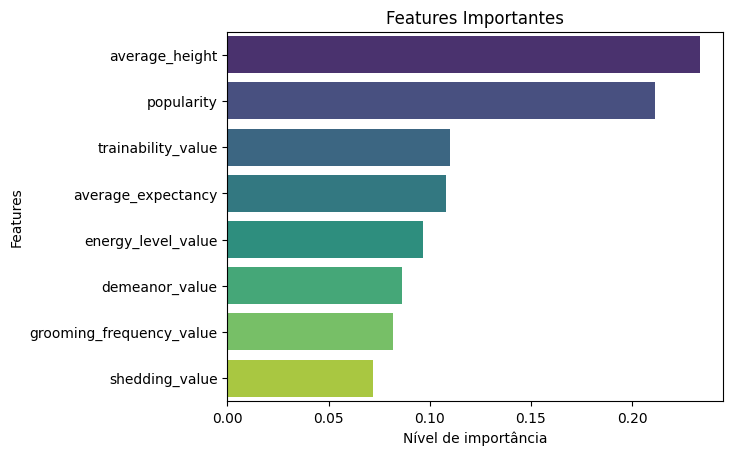

In [27]:

feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores, y=feature_scores.index, palette='viridis')

plt.xlabel('Nível de importância')
plt.ylabel('Features')
plt.title("Features Importantes")

plt.show()

Não criei um gráfico de curva de aprendizado visto que os resultados da acurácia, F1 Score e matriz de correlação mostram que o aprendizado do modelo não foi muito bom, indicando uma chance baixíssima de overfitting.

## MLP

In [28]:
clf = MLPClassifier(random_state=42, max_iter=1000).fit(X_resampled, y_resampled)

C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
y_pred = clf.predict(X_test)


<Figure size 1000x700 with 0 Axes>

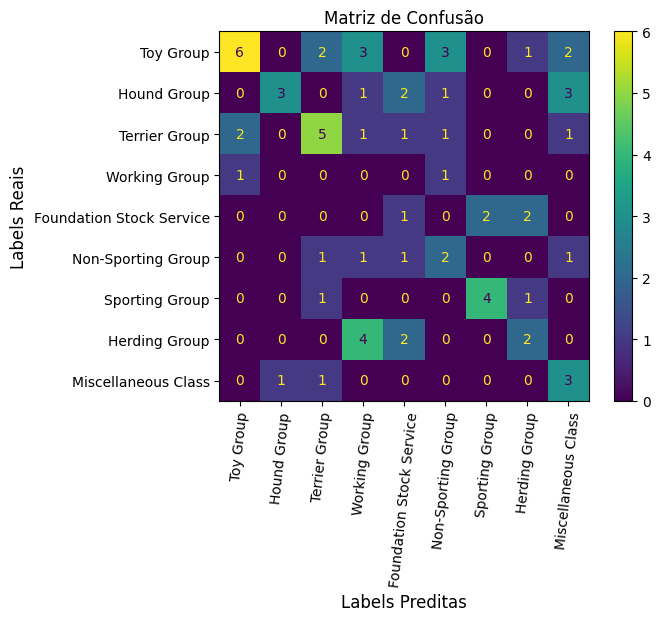

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Matriz de Confusão')
plt.xlabel('Labels Preditas', fontsize=12)
plt.ylabel('Labels Reais', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

Os resultados do Multi-Layer Perceptron não foram bons em nenhum dos casos, e a matriz de confusão nos prova isso, ele acaba se confundindo muito com várias classes diferentes em cada um dos resultados, o que explica a baixa acurácia que esse modelo atingiu

In [31]:

# Calculate metrics
accuracy_mlp = accuracy_score(y_test, y_pred) * 100
precision_mlp = precision_score(y_test, y_pred, average='weighted') * 100
recall_mlp = recall_score(y_test, y_pred, average='weighted') * 100
f1_mlp = f1_score(y_test, y_pred, average='weighted') * 100


print(f'Accuracy: {accuracy_mlp:.2f}%')
print(f'Precision: {precision_mlp:.2f}%')
print(f'Recall: {recall_mlp:.2f}%')
print(f'F1 Score: {f1_mlp:.2f}%')

Accuracy: 37.14%
Precision: 49.59%
Recall: 37.14%
F1 Score: 40.29%


Diferente dos outros modelos que mesmo baixos se mantiveras similares, o MLPClassifier apresentou um desempenho bem menor. Isso pode ser explicado pela complexidade do modelo, que pode ter dificuldade em aprender com
datasets pequenos, como os do caso apresentado.

### Comparando F1 Score dos diferentes modelos

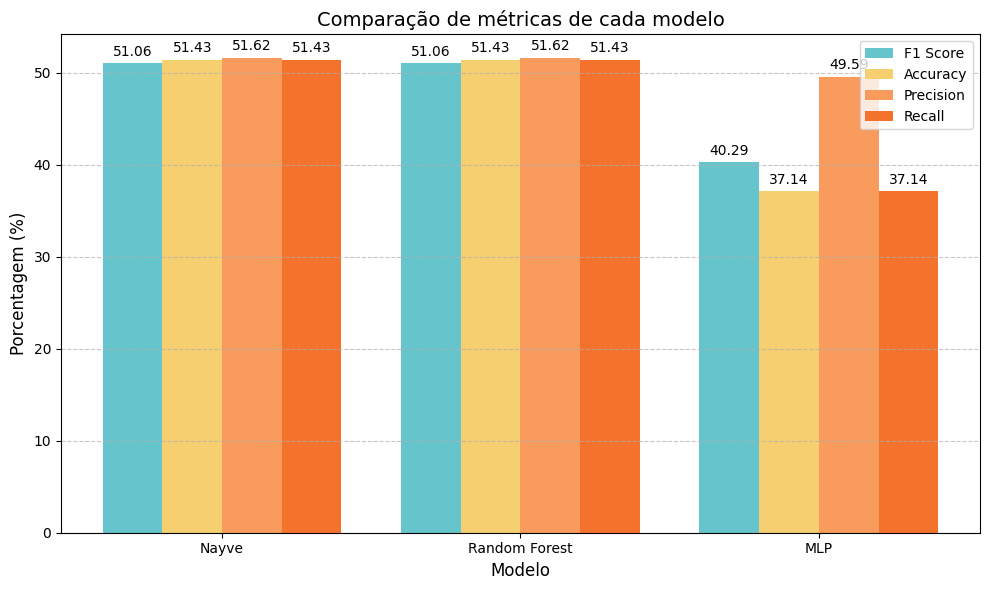

In [59]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Nayve', 'Random Forest', 'MLP']
f1_values = [f1_nayve, f1_rand, f1_mlp]
accuracy_values = [accuracy_nayve, accuracy_rand, accuracy_mlp]
precision_values = [precision_nayve, precision_rand, precision_mlp]
recall_values = [recall_nayve, recall_rand, recall_mlp]

bar_width = 0.2
spacing = 0.15
index = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

colors = ['#66c5cc', '#f6cf71', '#f89b5d', '#f3722c']

bar1 = plt.bar(index - 1.5 * bar_width, f1_values, bar_width, label='F1 Score', color=colors[0])
bar2 = plt.bar(index - 0.5 * bar_width, accuracy_values, bar_width, label='Accuracy', color=colors[1])
bar3 = plt.bar(index + 0.5 * bar_width, precision_values, bar_width, label='Precision', color=colors[2])
bar4 = plt.bar(index + 1.5 * bar_width, recall_values, bar_width, label='Recall', color=colors[3])

for bars in [bar1, bar2, bar3, bar4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.title('Comparação de métricas de cada modelo', fontsize=14)
plt.xticks(index, metrics, fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Assim, é possível observar que o Nayve Bayes foi o modelo que atingiu os melhores resultados a partir do conjunto de dados que eu forneci, algo que eu estranhei bastante, já que eu esperava que seria o exato oposto. 

Porém, a explicação disso e dá por ele ser um modelo mais simples, que reage de forma mais interessante para casos de datasets com tamanho inferior. Muito provavelmente se estivéssemos tratando de problemas com um conjunto com milhares de dados, o MLP atingiria um resultado mais interessante.

# Não Supervisionado

## K-means

In [33]:
df_X = df.drop(columns=["group"])

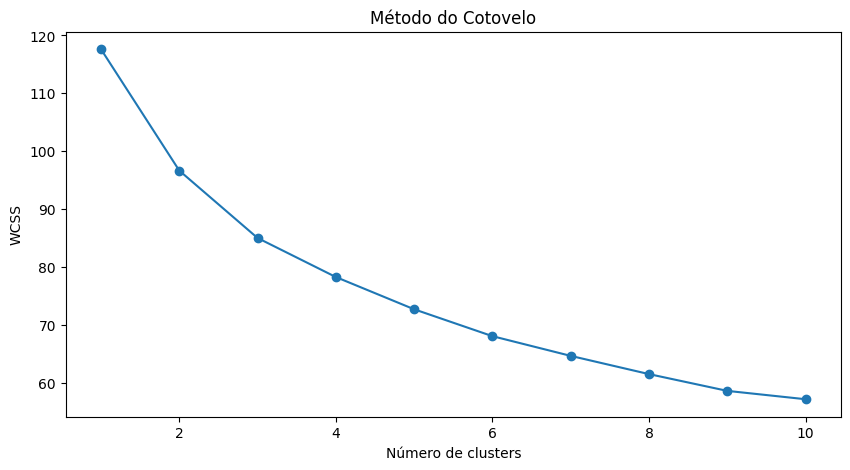

In [34]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

O método do cotovelo indica que o número ideal de clusters é 3, pois a partir desse ponto a redução da inércia
é menos significativa, por isso, para os testes de clustering, vou usar 3 clusters.

In [35]:
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init='auto')
kmeans.fit(df2)

KMeans(n_clusters=3, random_state=42)

In [36]:
kmeans2 = KMeans(n_clusters = 3, random_state = 42, n_init='auto')
kmeans2.fit(df_X)

KMeans(n_clusters=3, random_state=42)

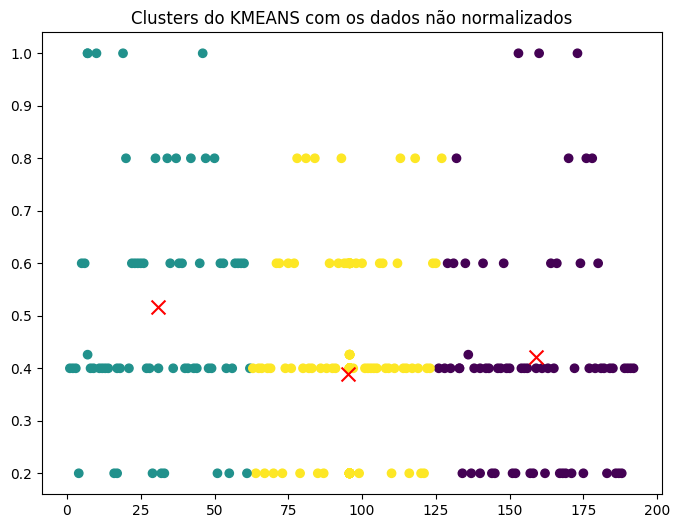

In [37]:
labels = kmeans.predict(df2)

plt.figure(figsize=(8, 6))
plt.scatter(df2.iloc[:, 0], df2.iloc[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('Clusters do KMEANS com os dados não normalizados')
plt.show()

### Métrica de avaliação do modelo (silhueta)

In [38]:
#Dados normalizados

silhouette_score(df_X, kmeans.fit_predict(df_X))

0.14934078446845964

In [39]:
#Dados não normalizados
silhouette_score(df2, kmeans2.fit_predict(df2))

0.48400833010674105

Analisando o silhouet score percebi que o modelo se comportou melhor com o dataset original, sem a normalização dos dados.
Isso pode ser explicado pela perda de informação causada pela normalização, que pode ter afetado a capacidade do modelo
de identificar os clusters.

## Hierarquia

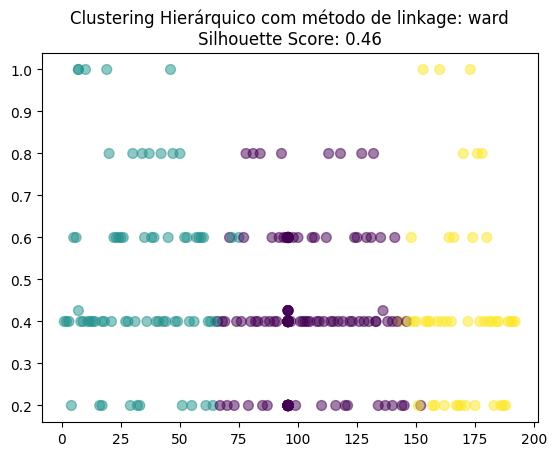

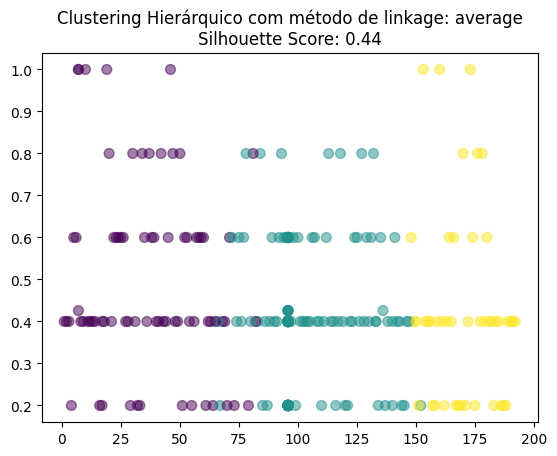

The Silhouette Score for ward linkage: 0.45547515636095365
The Silhouette Score for average linkage: 0.4439824534192753


In [40]:
#Clusters dos dados NÃO normalizados

k = 3
linkage_methods = ['ward', 'average']

silhouette_scores = {}

for linkage_method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    clustering.fit(df2)
    
    score = silhouette_score(df2, clustering.labels_)
    silhouette_scores[linkage_method] = score
    
    plt.figure()
    plt.scatter(df2.iloc[:, 0], df2.iloc[:, 1], c=clustering.labels_, cmap='viridis', s=50, alpha=0.5)
    plt.title(f'Clustering Hierárquico com método de linkage: {linkage_method}\nSilhouette Score: {score:.2f}')
    plt.show()

for method, score in silhouette_scores.items():
    print(f"The Silhouette Score for {method} linkage: {score}")


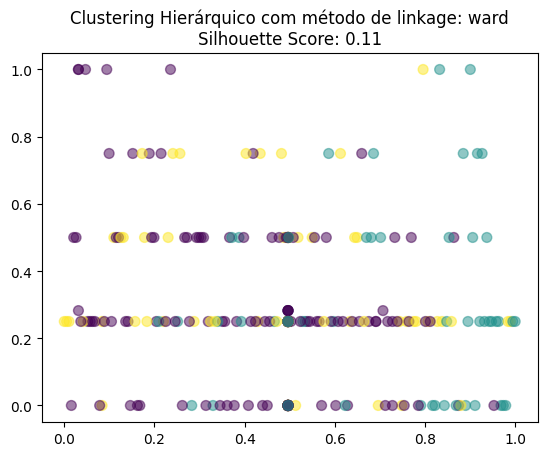

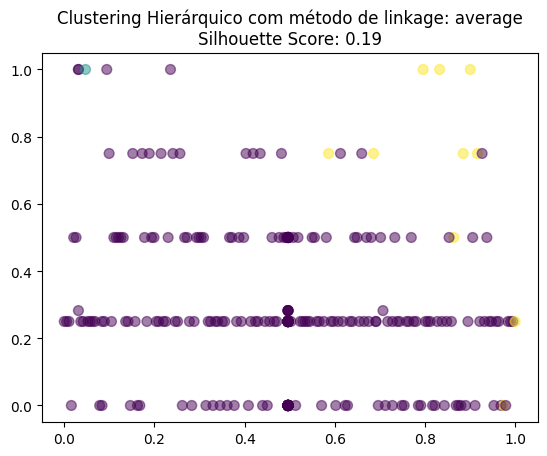

The Silhouette Score for ward linkage: 0.11046839610150705
The Silhouette Score for average linkage: 0.19266231439447745


In [41]:
#Clusters dos dados normalizados

k = 3
linkage_methods = ['ward', 'average']

silhouette_scores = {}

for linkage_method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    clustering.fit(df_X)
    
    score = silhouette_score(df_X, clustering.labels_)
    silhouette_scores[linkage_method] = score
    
    plt.figure()
    plt.scatter(df_X.iloc[:, 0], df_X.iloc[:, 1], c=clustering.labels_, cmap='viridis', s=50, alpha=0.5)
    plt.title(f'Clustering Hierárquico com método de linkage: {linkage_method}\nSilhouette Score: {score:.2f}')
    plt.show()

for method, score in silhouette_scores.items():
    print(f"The Silhouette Score for {method} linkage: {score}")

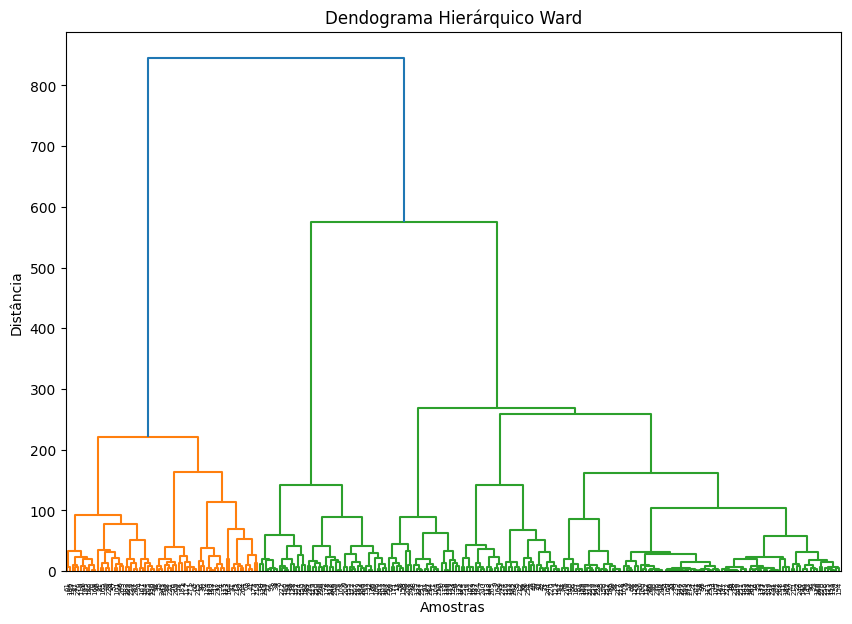

In [42]:
#Apenas como uma forma de entender melhor os clusters, decidi plotar um dendograma do método de linkage ward. 
#Para os dados não normalizados
Z = sch.linkage(df2, method='ward')

plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Dendograma Hierárquico Ward')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()


O mesmo aconteceu na hierarquização, onde o modelo se comportou melhor com o dataset original, sem a normalização dos dados.
Além disso, consegui observar para o caso do dataset original, que o método de linkage 'ward' apresentou um melhor resultado
ligeiramente melhor que o método 'average'. Essa avaliação foi feita com base no silhouet score, que é uma métrica que avalia a
qualidade dos clusters formados pelo modelo.



Também é possível observar visualmente que os clusters dos dados normalizados ficaram super bagunçados, não seguindo um padrão 
claro de separação, o que pode ter influenciado diretamente no resultado do silhouet score.


assim, a melhor forma dentre as formas de aprendizado não supervisionado foi o KMeans, que apresentou um silhouet score de 0.48
o que foi melhor que ambos os métodos de linkage da hierarquização.

### Agora testando com k = 9

Apenas por desencargo de consciência, decidi testar o KMEANS com o k=9, número de classes que existiam na coluna group antes de eu ter removido a coluna

In [43]:
kmeans = KMeans(n_clusters = 9, random_state = 42, n_init='auto')
kmeans.fit(df2)

silhouette_score(df2, kmeans.fit_predict(df2))

0.37955359505613206

Observei que o silhouet score para os dados não normalizados (que estavam atingindo o melhor resultado) ficou com resultado pior quando eu considerei 9 clusters invés de 3, que foi o valor recomendado a partir do teste do cotovelo.

## Conclusões finais:

Consegui observar com esse notebook o impacto que o tamanho da amostra de dados possui no modelo, muitas das técnicas que eu sou acostumado a usar não tiveram um impacto muito bom justamente devido à baixa quantidade de amostras que me foram oferecidas.

De qualquer forma, observei que o Nayve Bayes foi o modelo supervisionado que atingiu o melhor resultado, com F1-Score de 51%, e o modelo não supervisionado que dividiu melhor os clusters foi o K-means, que atingiu Silhouet Score de 0.48, suficiente para deixar uma divisão relativamente boa dos clusters com base na semalhança dos dados.

Além diso, achei muito interessante usar o método de Random Forest para identificar os atributos com maior impacto no modelo, onde pude analisar que a média do peso e a popularidade são fatores com muito impacto no resultado do grupo do cachorro.

Por fim, acho importante ressaltar que tentei usar outras técnicas de pré-processamento para melhorar o resultado do modelo, porém, elas não apresentaram nenhuma melhora relevante. Pensei também em rodar um GRIDSearch, mas a falta de explicabilidade fez com que eu preferisse não aplicar essa técnica.